In [1]:
from spikeforest2_utils import AutoRecordingExtractor, AutoSortingExtractor
import kachery as ka

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from neurodsp.filt import filter_signal
from neurodsp.spectral import compute_spectrum

from fooof import FOOOF
from bycycle import Bycycle
from bycycle.spikes.objs import Spikes

In [2]:
# Configure kachery to download data from the public database
ka.set_config(fr='default_readonly')

# Specify the recording and ground truth sorting
recording_path = 'sha1dir://779d96521176077ec260ef99573dea3b772c74e6.paired_crcns/d11221_d11221.001'
sorting_true_path = 'sha1dir://779d96521176077ec260ef99573dea3b772c74e6.paired_crcns/d11221_d11221.001/firings_true.mda'

recording = AutoRecordingExtractor(recording_path, download=True)
sorting_true = AutoSortingExtractor(sorting_true_path)

In [3]:
fs = 20000

sigs = recording.get_traces()

# Use first electrode
sig = sigs[0]
del sigs

### Fit Spike Waveforms

In [4]:
sig_spikes = filter_signal(sig, fs, 'bandpass', (300, 3000), remove_edges=False)
times = np.arange(0, len(sig_spikes)/fs, 1/fs)

sp = Spikes()

# Extrema/Zero-crossings voltage features
sp.fit(sig_spikes, fs, (1000, 2500), n_gaussians=3, std=3,
       tol=1e-2, chunksize=500, progress='tqdm.notebook')

Computing Bycycle Features:   0%|          | 0/9774 [00:00<?, ?it/s]

### Confirm Beta Oscillation

array([[ 3.26109601,  0.86080211,  3.06766428],
       [24.06378949,  0.23472113,  7.34003186],
       [47.89306662,  0.2461429 ,  3.        ]])

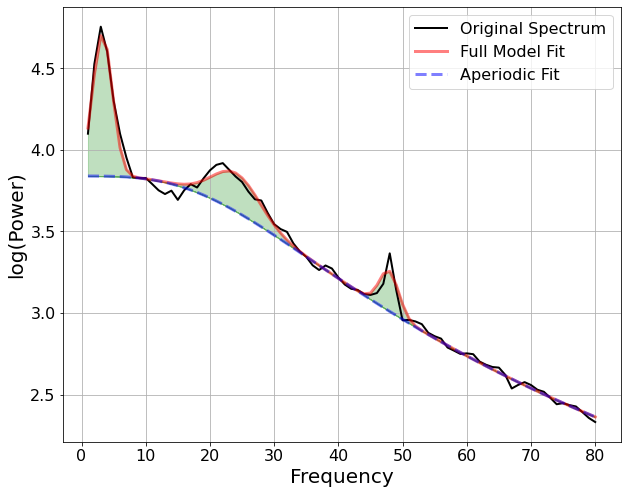

In [5]:
sig_lfp = filter_signal(sig, fs, 'bandpass', (1, 100), remove_edges=False)

freqs, powers = compute_spectrum(sig_lfp, fs)

fm = FOOOF(aperiodic_mode='knee', peak_width_limits=(3, 12.0), max_n_peaks=3)

fm.fit(freqs, powers, freq_range=(1, 80))

fm.plot(plt_log=False, plot_peaks='shade', file_name='specparam.jpg', save_fig=True)

fm.get_params('peak_params')

### Determine Beta Cyclepoints

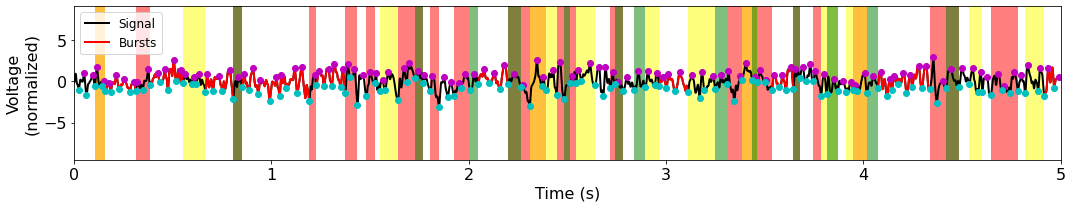

In [7]:
byc = Bycycle()
byc.fit(sig_lfp, fs, (17, 32))
byc.plot(xlim=(0, 5), plot_only_results=True)

### Segment Beta LFP

In [8]:
peaks = byc.df_features['sample_peak'].values

rises = byc.df_features['sample_zerox_rise'].values
decays = byc.df_features['sample_zerox_decay'].values

last_troughs = byc.df_features['sample_last_trough'].values
next_troughs = byc.df_features['sample_next_trough'].values

rise_starts = ((rises - last_troughs) / 2).astype(int) + last_troughs
rise_ends = ((peaks - rises) / 2).astype(int) + rises

decay_starts = ((decays - peaks) / 2).astype(int) + peaks
decay_ends = ((next_troughs - decays) / 2).astype(int) + decays

In [9]:
locs = np.zeros(len(sig))

cps = zip(last_troughs, next_troughs, rise_starts,
          rise_ends, decay_starts, decay_ends)

for t_start, t_end, r_start, r_end, d_start, d_end in cps:
    
    # Trough
    locs[t_start:r_start] = 1
    locs[d_end:t_end] = 1
    
    # Rise
    locs[r_start:r_end] = 2
    
    # Peak
    locs[r_end:d_start] = 3
    
    # Decay
    locs[d_start:d_end] = 4

### Plot Shape Distributions

In [10]:
spike_features = sp.df_features.copy()

spike_troughs = spike_features['sample_trough'].values

locs_spikes = locs[spike_troughs]

locs_spikes_str = np.empty(locs_spikes.shape, dtype="S6")
locs_spikes_str[np.where(locs_spikes == 0)[0]] = None
locs_spikes_str[np.where(locs_spikes == 1)[0]] = 'Trough'
locs_spikes_str[np.where(locs_spikes == 2)[0]] = 'Rise'
locs_spikes_str[np.where(locs_spikes == 3)[0]] = 'Peak'
locs_spikes_str[np.where(locs_spikes == 4)[0]] = 'Decay'

locs_spikes_str = locs_spikes_str.tolist()
locs_spikes_str = [x.decode() for x in locs_spikes_str]
locs_spikes_str = [x if x != 'None' else None for x in locs_spikes_str]
spike_features['lfp_phase'] = locs_spikes_str

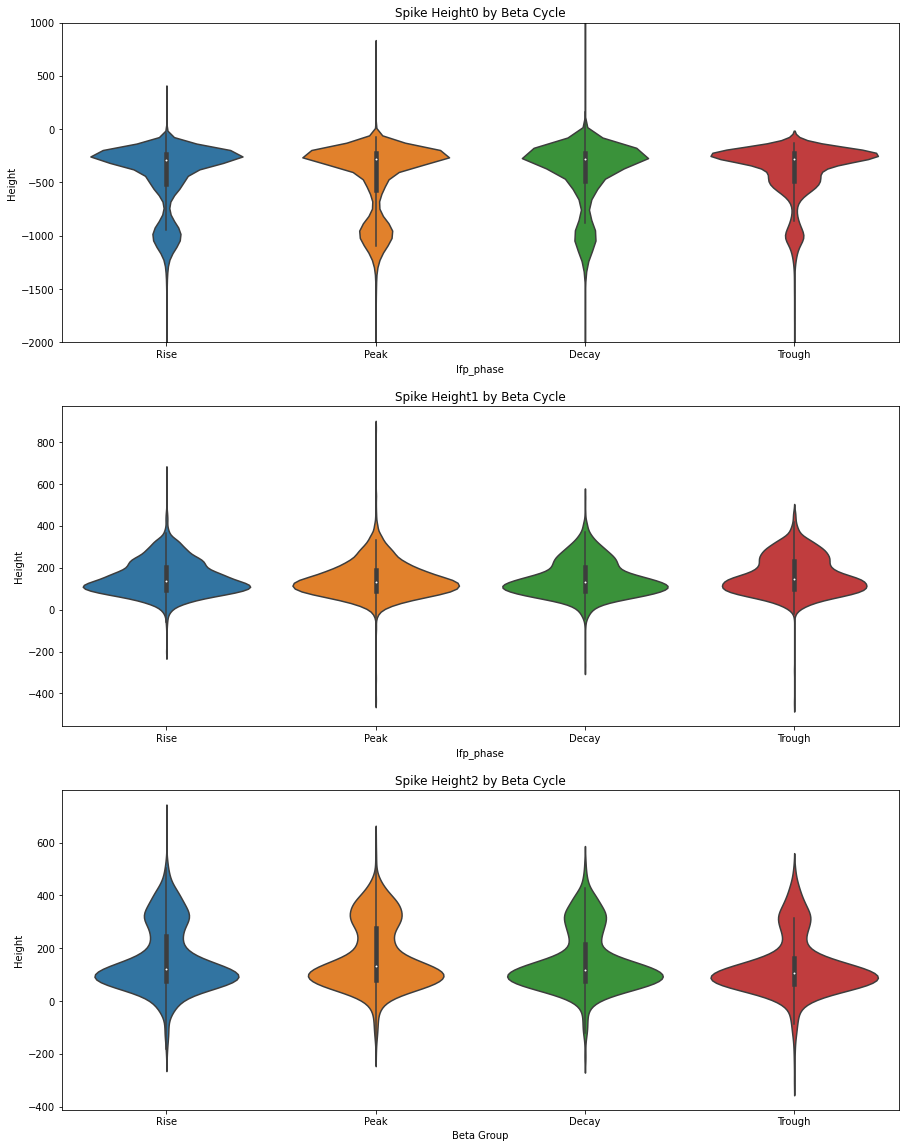

In [27]:
fig, axes = plt.subplots(nrows=3, figsize=(15, 20))

sns.violinplot(x="lfp_phase", y="height0", data=spike_features, ax=axes[0], linewidth=1.5)
sns.violinplot(x="lfp_phase", y="height1", data=spike_features, ax=axes[1], linewidth=1.5)
sns.violinplot(x="lfp_phase", y="height2", data=spike_features, ax=axes[2], linewidth=1.5)

for ax in axes:
    ax.set_ylabel('Height')
    
axes[0].set_ylim(-2000, 1000)

axes[0].set_title('Spike Height0 by Beta Cycle')
axes[1].set_title('Spike Height1 by Beta Cycle')
axes[2].set_title('Spike Height2 by Beta Cycle')

axes[-1].set_xlabel('Beta Group')

plt.savefig('plt_height.jpg', transparent=False, dpi=500)

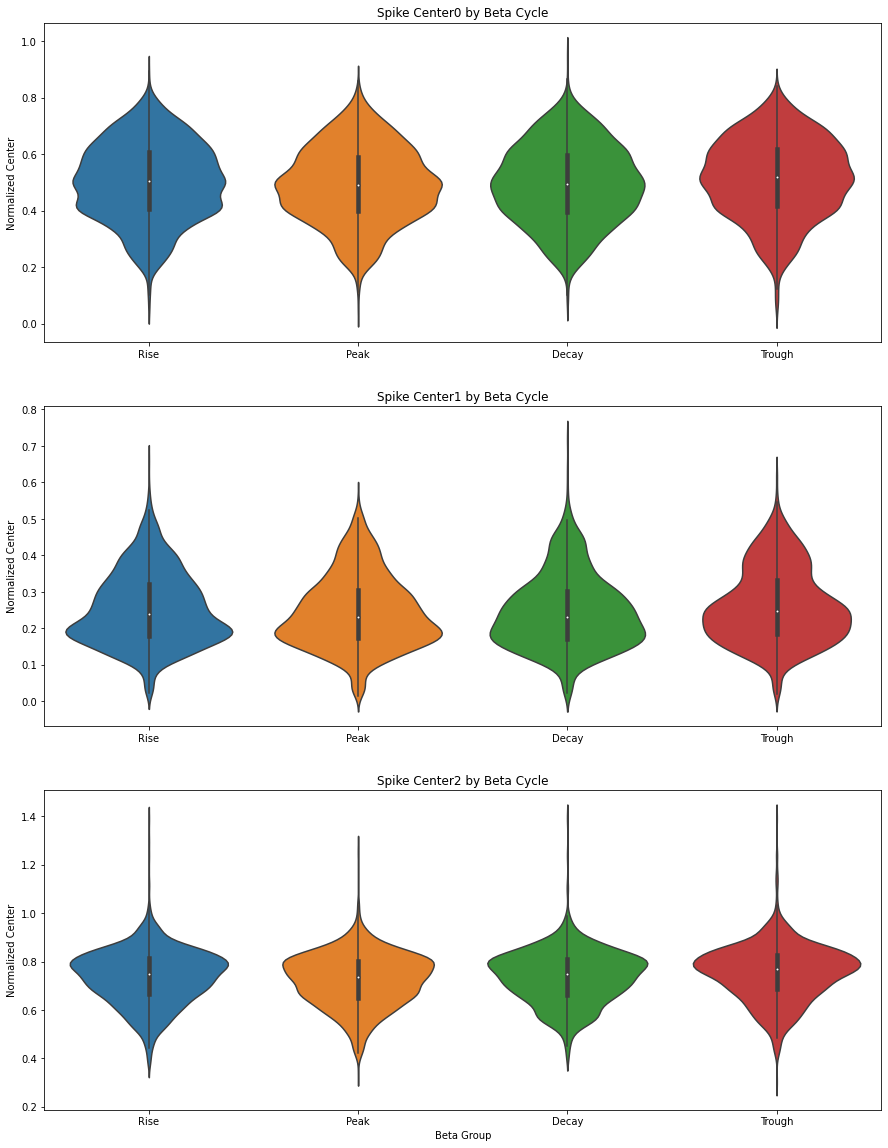

In [32]:
fig, axes = plt.subplots(nrows=3, figsize=(15, 20))

sns.violinplot(x="lfp_phase", y="center0", data=spike_features, ax=axes[0], linewidth=1.5)
sns.violinplot(x="lfp_phase", y="center1", data=spike_features, ax=axes[1], linewidth=1.5)
sns.violinplot(x="lfp_phase", y="center2", data=spike_features, ax=axes[2], linewidth=1.5)

for ax in axes:
    ax.set_ylabel('Normalized Center')
    ax.set_xlabel('')

axes[0].set_title('Spike Center0 by Beta Cycle')
axes[1].set_title('Spike Center1 by Beta Cycle')
axes[2].set_title('Spike Center2 by Beta Cycle')

axes[-1].set_xlabel('Beta Group')

plt.savefig('plt_center.jpg', transparent=False, dpi=500)

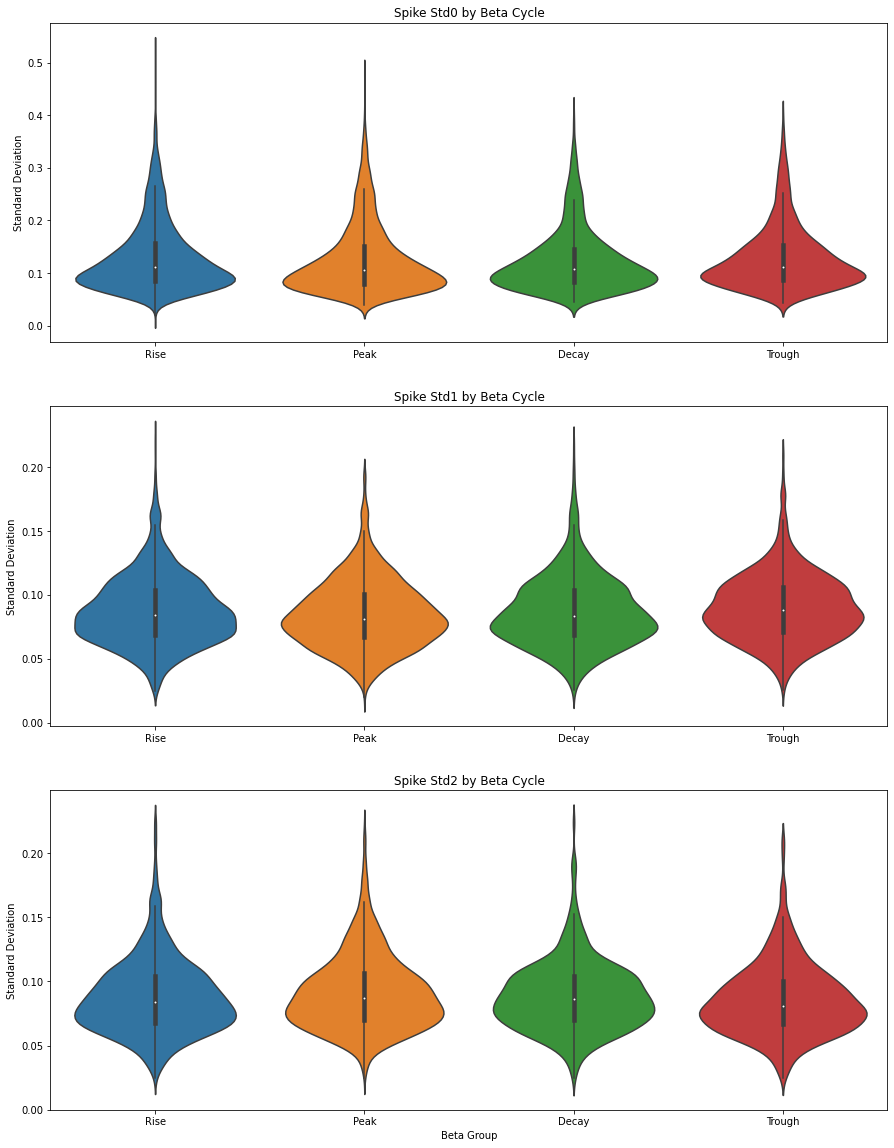

In [29]:
fig, axes = plt.subplots(nrows=3, figsize=(15, 20))

sns.violinplot(x="lfp_phase", y="std0", data=spike_features, ax=axes[0], linewidth=1.5)
sns.violinplot(x="lfp_phase", y="std1", data=spike_features, ax=axes[1], linewidth=1.5)
sns.violinplot(x="lfp_phase", y="std2", data=spike_features, ax=axes[2], linewidth=1.5)

for ax in axes:
    ax.set_ylabel('Standard Deviation')
    ax.set_xlabel('')
    
axes[0].set_title('Spike Std0 by Beta Cycle')
axes[1].set_title('Spike Std1 by Beta Cycle')
axes[2].set_title('Spike Std2 by Beta Cycle')

axes[-1].set_xlabel('Beta Group')

plt.savefig('plt_std.jpg', transparent=False, dpi=500)

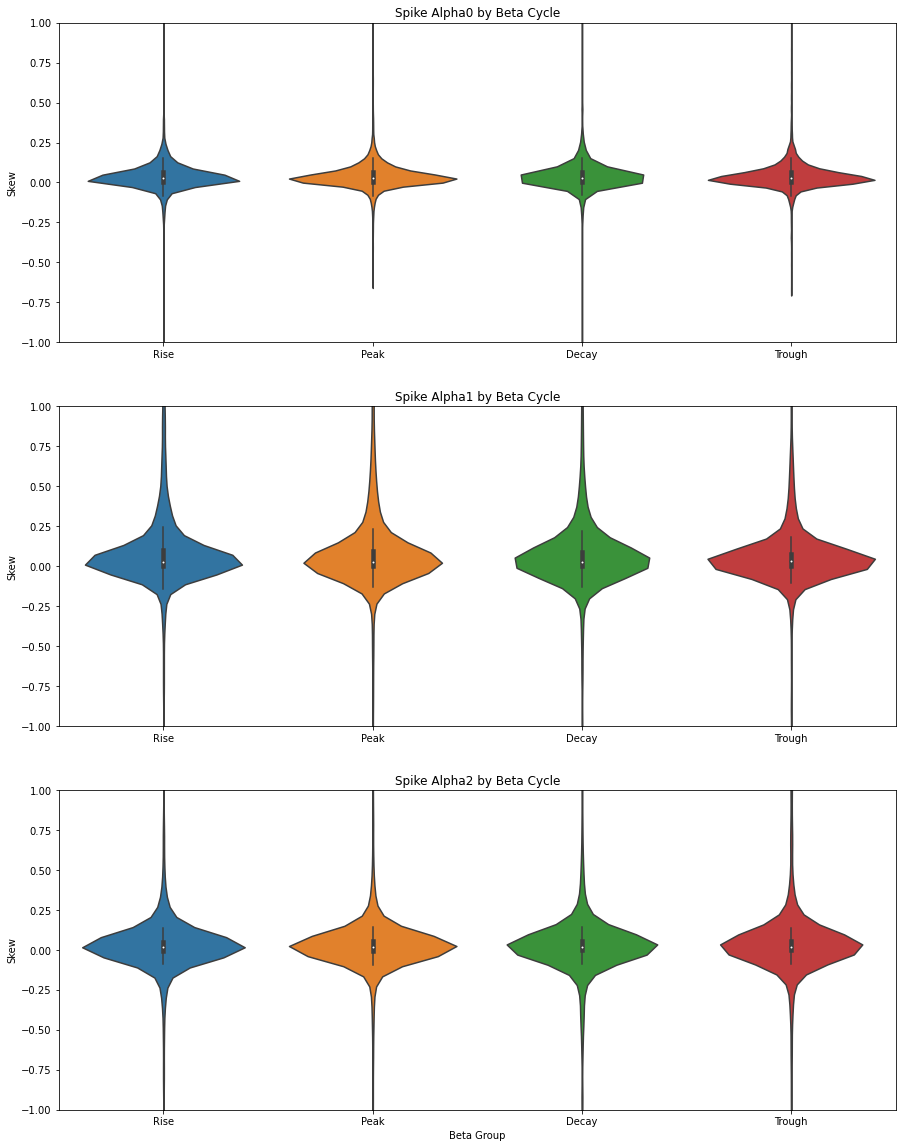

In [30]:
fig, axes = plt.subplots(nrows=3, figsize=(15, 20))

sns.violinplot(x="lfp_phase", y="alpha0", data=spike_features, ax=axes[0], linewidth=1.5)
sns.violinplot(x="lfp_phase", y="alpha1", data=spike_features, ax=axes[1], linewidth=1.5)
sns.violinplot(x="lfp_phase", y="alpha2", data=spike_features, ax=axes[2], linewidth=1.5)

for ax in axes:
    ax.set_ylabel('Skew')
    ax.set_xlabel('')

axes[0].set_title('Spike Alpha0 by Beta Cycle')
axes[1].set_title('Spike Alpha1 by Beta Cycle')
axes[2].set_title('Spike Alpha2 by Beta Cycle')

for ax in axes:
    ax.set_ylim(-1, 1)
    
axes[-1].set_xlabel('Beta Group')
plt.savefig('plt_alpha.jpg', transparent=False, dpi=500)

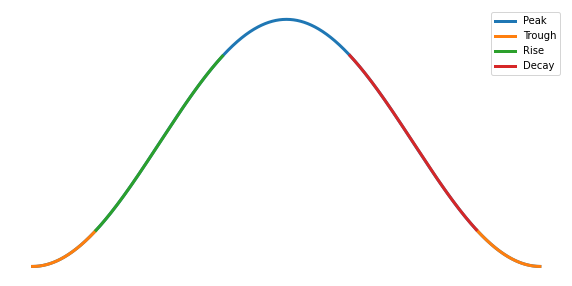

In [31]:
from neurodsp.sim import sim_oscillation

ys = sim_oscillation(1, 1000, 1, phase='min')
xs = np.arange(0, len(ys))

fig = plt.figure(figsize=(10, 5))

plt.plot(ys, lw=3, label='Peak')

plt.plot(ys[:125], color='C1', lw=3, label='Trough') 
plt.plot(xs[-125:], ys[-125:], color='C1', lw=3)

plt.plot(xs[125:375], ys[125:375], color='C2', lw=3, label='Rise')

plt.plot(xs[625:875], ys[625:875], color='C3', lw=3, label='Decay')

plt.axis('off')

plt.legend()

plt.savefig('ranges.jpg', dpi=500)